In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28

In [ ]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [ ]:
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model

In [ ]:
# Train the model
model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)

In [ ]:
# # Test the trained model: reconstruction
# batch = mnist.test.next_batch(100)
# x_reconstructed = model.reconstructor(batch[0])

# n = np.sqrt(model.batch_size).astype(np.int32)
# I_reconstructed = np.empty((h*n, 2*w*n))
# for i in range(n):
#     for j in range(n):
#         x = np.concatenate(
#             (x_reconstructed[i*n+j, :].reshape(h, w), 
#              batch[0][i*n+j, :].reshape(h, w)),
#             axis=1
#         )
#         I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

# plt.figure(figsize=(10, 20))
# plt.imshow(I_reconstructed, cmap='gray')

In [ ]:
# # Test the trained model: generation
# # Sample noise vectors from N(0, 1)
# z = np.random.normal(size=[model.batch_size, model.n_z])
# x_generated = model.generator(z)

# n = np.sqrt(model.batch_size).astype(np.int32)
# I_generated = np.empty((h*n, w*n))
# for i in range(n):
#     for j in range(n):
#         I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

# plt.figure(figsize=(8, 8))
# plt.imshow(I_generated, cmap='gray')

In [8]:
# tf.reset_default_graph()
# # Train the model with 2d latent space
# model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=50, n_z=2)

[Epoch 0] Loss: 184.410491943, Recon loss: 179.581893921, Latent loss: 4.82858848572
[Epoch 5] Loss: 170.813476562, Recon loss: 165.470031738, Latent loss: 5.34344482422
[Epoch 10] Loss: 176.266113281, Recon loss: 171.056091309, Latent loss: 5.21002101898
[Epoch 15] Loss: 145.848312378, Recon loss: 139.958526611, Latent loss: 5.88977909088
[Epoch 20] Loss: 154.423187256, Recon loss: 148.694488525, Latent loss: 5.728703022
[Epoch 25] Loss: 150.980651855, Recon loss: 145.063491821, Latent loss: 5.91716480255
[Epoch 30] Loss: 141.475616455, Recon loss: 135.510848999, Latent loss: 5.96476268768
[Epoch 35] Loss: 148.845458984, Recon loss: 142.821472168, Latent loss: 6.0239906311
[Epoch 40] Loss: 147.773208618, Recon loss: 141.647750854, Latent loss: 6.12545967102
[Epoch 45] Loss: 138.380050659, Recon loss: 132.346893311, Latent loss: 6.03315353394
Done!


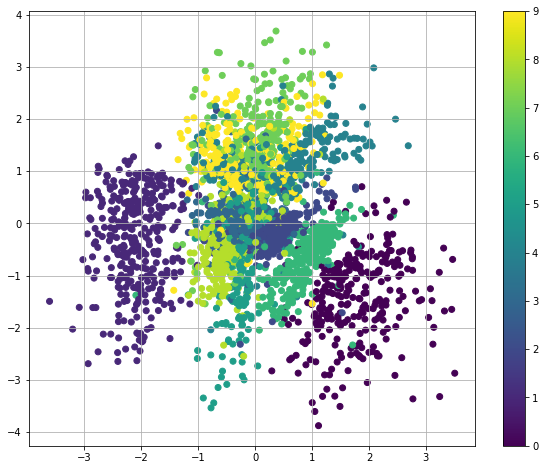

In [9]:
# # Test the trained model: transformation
# batch = mnist.test.next_batch(3000)
# z = model_2d.transformer(batch[0])
# plt.figure(figsize=(10, 8)) 
# plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
# plt.colorbar()
# plt.grid()

In [1]:
# # Test the trained model: transformation
# n = 20
# x = np.linspace(-2, 2, n)
# y = np.linspace(-2, 2, n)

# I_latent = np.empty((h*n, w*n))
# for i, yi in enumerate(x):
#     for j, xi in enumerate(y):
#         z = np.array([[xi, yi]]*model_2d.batch_size)
#         x_hat = model_2d.generator(z)
#         I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

# plt.figure(figsize=(8, 8))        
# plt.imshow(I_latent, cmap="gray")

In [ ]:
#save digit 10 by 9 grid
f, b = plt.subplots(10,9)
for i in range(10):
    indice = np.random.choice(np.where(int_label == i)[0],2,replace = False)
    z = model.transformer(mnist.test.images[indice])
    a_z = np.zeros((9,z.shape[1]))
    diff = (z[1,:] - z[0,:])/8
    a_z[0,:] = z[0]
    a_z[8,:] = z[1]
    for j in range(1,8):
        a_z[j,:] = a_z[j-z,:] + diff
    g = model.generator(a_z)
    for j in range(9):
        b[i,j].imshow(g[j].reshape(28,28))
        b[i,j].set_title("Digit1:" + str(int_label[indice[0]]) + ", " + "Digit2:" + str(int_label[indice[1]]) + ", " + "Image: "+ str(j))
f.subplots_adjust(hspace = 1, wspace = 1)
f.set_figheight(50)
f.set_figwidth(40)
plt.savefig("p1.png")

In [ ]:
#save digit 10 by 9 grid
f, b = plt.subplots(10,9)
for i in range(10):
    indice = np.random.choice(np.where(int_label == i)[0],2,replace = False)
    z = model.transformer(mnist.test.images[indice])
    a_z = np.zeros((9,z.shape[1]))
    diff = (z[1,:] - z[0,:])/8
    a_z[0,:] = z[0]
    a_z[8,:] = z[1]
    for j in range(1,8):
        a_z[j,:] = a_z[j-z,:] + diff
    g = model.generator(a_z)
    for j in range(9):
        b[i,j].imshow(g[j].reshape(28,28))
        b[i,j].set_title("Digit1:" + str(int_label[indice[0]]) + ", " + "Digit2:" + str(int_label[indice[1]]) + ", " + "Image: "+ str(j))
f.subplots_adjust(hspace = 1, wspace = 1)
f.set_figheight(50)
f.set_figwidth(40)
plt.savefig("p1.png")